# 14. Introduction to Neural networks via regression

In the last chapter we have seen how to perform a linear regression, i.e. finding a model to describe a feature $y$ with a series of other features $x_i$: $y = w_0 * x_0 + w_1 * x_1 + \dots + b$. In particular we also saw how we could use the local slope in a measured error to "discover" the best model via *Gradient Descent*.

In this chapter, we are going to see how we can solve this problem by formulating it as a **Neural Network**. These networks which are used e.g. in Deep Learning, might sound like a very complex tool, but are in fact relatively simple to understand and linear regression is a good example to understand the basics.

## What is a Neural Network

These networks take their name from early models that tried to "reproduce" what happens with neurons in our brains. Neurons are specialized cell types that are connected to each other via axons as shown below (left, https://commons.wikimedia.org/wiki/File:Two_neurons_connected.svg):

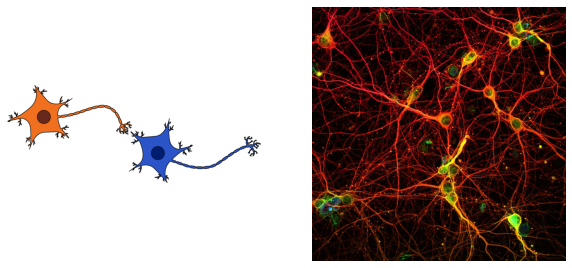

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(plt.imread("images/Two_neurons_connected.png"))
ax[1].imshow(plt.imread("images/neurons.jpg"))
ax[0].set_axis_off()
ax[1].set_axis_off()

Neurons communicate via electrical signals and the strength of the connection between two neurons can change with learning: if e.g. two neurons need to communicate often the connection becomes stronger. These neurons are not just connected as pairs but form very large networks of interconnected cells as shown above (right, https://commons.wikimedia.org/wiki/File:Neuronal_web.tif, [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/deed.en)).

Computational neural networks try to reproduce this scheme: they are composed of **nodes** (neurons, $x_1, x_2 \dots$ below) linked to each others by connectors (axons) of a certain **weight** (connection strength, $w_1, w_2, \dots$ below). Very often they are represented as shown below.

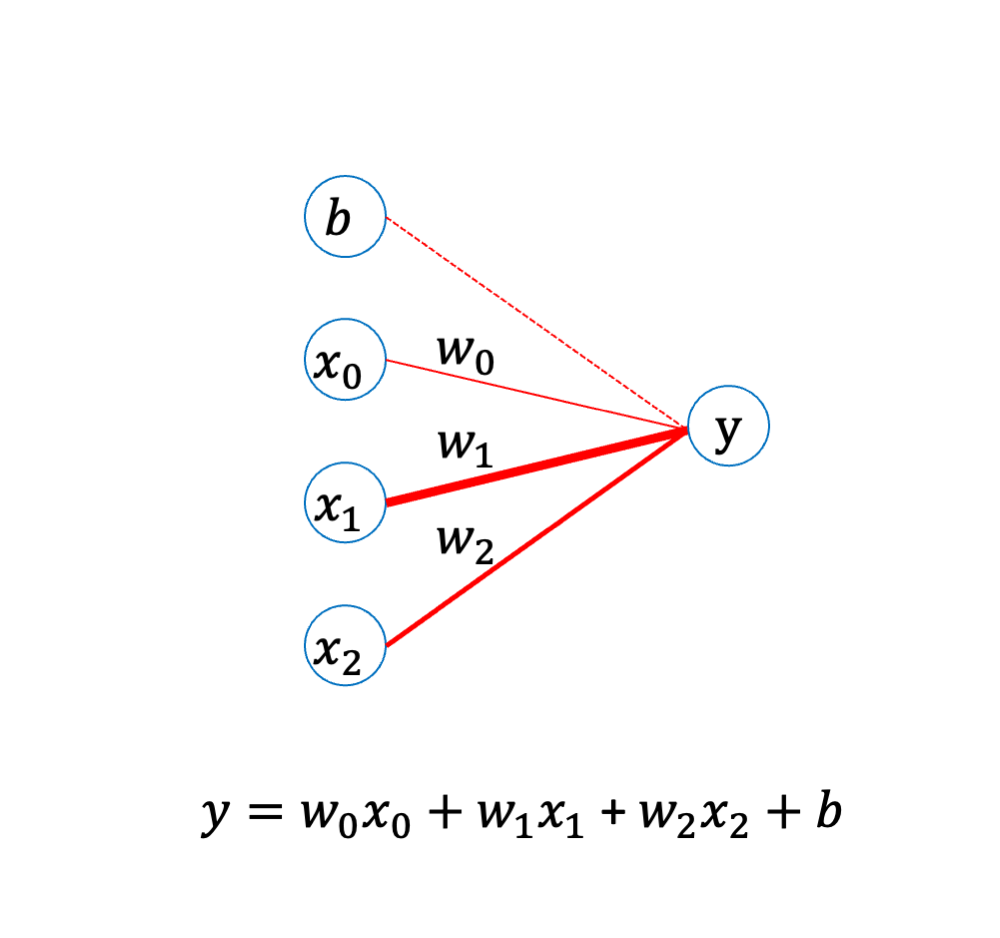

In [9]:
from IPython.display import Image, display
Image('images/networks/networks1.png', width=500)

The above neural network is the simplest you can create and actually represents the **exact same model as the one of our linear regression model**. The way to interpret the above graph is indeed $y = w_0 * x_0 + w_1 * x_1 + w_2 * x_2 + b$.

## Tensors

We will learn now how we can implement this simple NN practically. While the list of $x_1, x_2, \dots$ could in principle be represented as vectors or Numpy arrays, we actually have to resort to another type of array, which however works almost identically to Numpy arrays. That new type of array is called a **tensor** and is implemented in all Deep Learning libraries. Here we use the PyTorch tensor, but similar objects exist in Tensorflow, Keras, JAX etc. The reasons we need a new type of array are: 1. we need to be able to do computations on a Graphical Processing Unit (GPU) for speed, and 2. we need a special set of methods attached to the tensor in order to perform the optimization step (specifically the step where we search for the steepest slope during gradient descent).

Let's import the PyTorch library and create a simple tensor:

In [10]:
import torch

In [11]:
torch_array = torch.zeros((3,4))
torch_array

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

We see that we have an identical function ```zeros``` to what we had in Numpy. This is not the only example: many function from Numpy have been "translated" to PyTorch.

## Layer

The series $x_0, x_1, x_2$ that we have in the above drawing of a NN represents a sort of "unit" in a neural network and is called a **layer**. As we will have more such units later, we *index* it, here with 0.

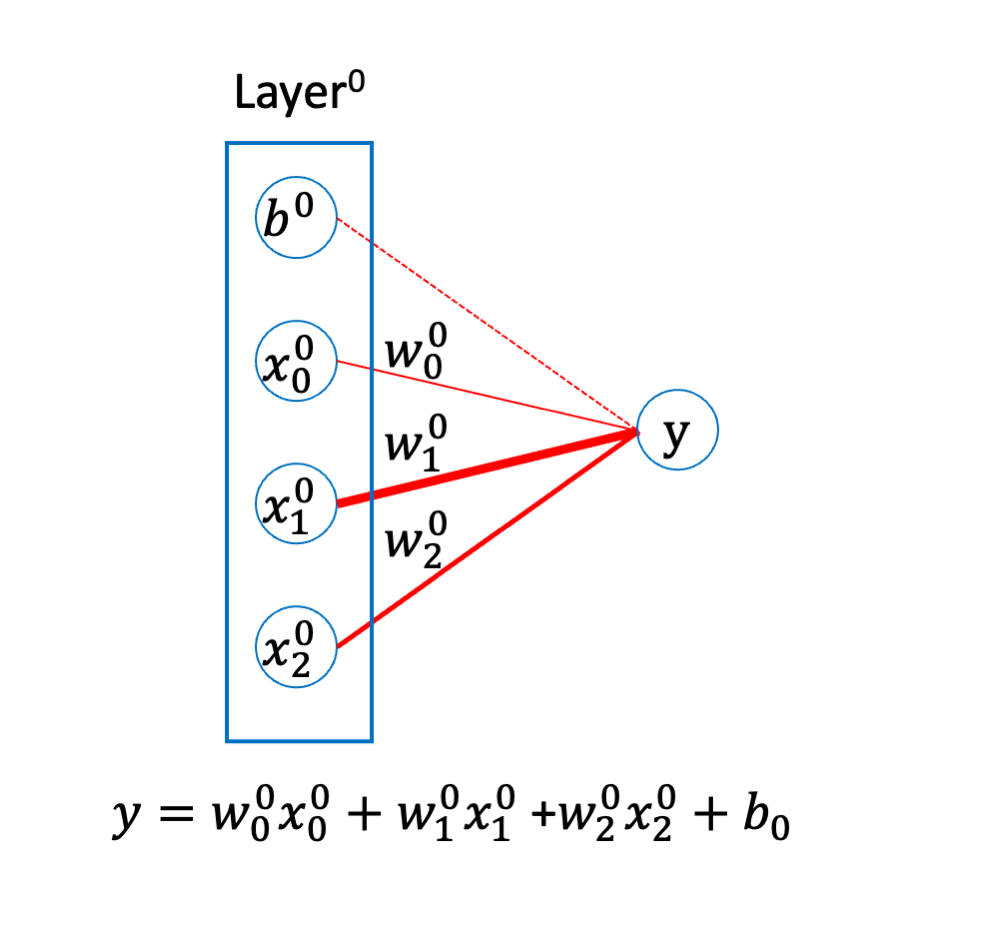

In [12]:
Image('images/networks/networks2.png', width=500)

In this specific example with a single layer, the $x_i^0$ are simply our inputs (or features) and the values that we need to optimize are the $w_i^0$.

These layers can be much larger than three numbers, and we don't have to create each element individually. Instead we use a submodule of PyTorch called ```nn``` which creates such layers for us:

In [13]:
from torch import nn

Such a layer is defined by the number of inputs and outputs. In our example above we have three inputs $x_0$, $x_1$ and $x_2$ and a single output $y$. We can define the NN using the ```Linear``` layer:

In [7]:
lin_layer = nn.Linear(in_features=3, out_features=1)
lin_layer

Linear(in_features=3, out_features=1, bias=True)

We see above that we have the information ```bias==True```. This means that our model incorporates this constant value (that we have in our sketch as ```b```) and which is basically the intercept in our linear model. We can count see the parameters of our model:

In [8]:
list(lin_layer.parameters())

[Parameter containing:
 tensor([[-0.5172, -0.4553,  0.4848]], requires_grad=True),
 Parameter containing:
 tensor([0.2536], requires_grad=True)]

We have indeed three parameters for the $w_i$ and one for the bias, so four parameters. We also see that they are initialized with random values. Finally, we see the indication ```requires_grad=True```. This means that those parameters are taken into account when computing the steepest slope for the gradient descent!

We will see later that we could have more than one layer in our model. So we need a way to "stack" them and this can be done via the ```Sequential``` object:

In [9]:
model = nn.Sequential(lin_layer)

Now we have finished defining a model and we can try to optimize it and then use it for prediction.

## Evaluating the networks

When we have an equation like $y = w_0 * x_0 + w_1 * x_1 + w_2 * x_2 + b$, we know that we can obtain the predicted value of $y$ by using the correct values of the $w_i$ and a set of values for the features $x_i$ (e.g. in the wine dataset, $y$ is the price, $w_0$ could be the density etc...

To do that computation with our neural network we can simply pass a list of numbers corresponding to all our features $[x_0, x_1, x_2]$ to the network to get the output value. First we have to transform that list into a tensor (like we did e.g. with ```np.array([5,2,3])```:

In [10]:
tensor = torch.tensor([3,2,5], dtype=torch.float32)

In [11]:
tensor

tensor([3., 2., 5.])

Now we can simply pass it as an input to our model:

In [12]:
model(tensor)

tensor([0.2155], grad_fn=<AddBackward0>)

## Practical example

The goal is now to do the same work as before: find the best parameters to describe a dataset. For this we construct as simple dataset: just a line $y=w_0 * x_0 + b$ with a bit of noise added:

In [14]:
import numpy as np

x_val = torch.arange(0,10,0.1)
y_val = 3 + 10 * x_val + 3*torch.tensor(np.random.randn(len(x_val)), dtype=torch.float32)

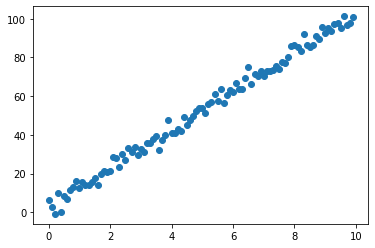

In [14]:
plt.plot(x_val, y_val, 'o');

As we have a single parameter to train, the number of input features is just 1 and we have just two parameters to train $w_0$ and $b$:

In [16]:
lin_layer = nn.Linear(in_features=1, out_features=1)
list(lin_layer.parameters())

[Parameter containing:
 tensor([[-0.2355]], requires_grad=True),
 Parameter containing:
 tensor([0.5502], requires_grad=True)]

In [17]:
model = nn.Sequential(lin_layer)

When we learned about regression in previous chapters, we saw that in order to optimize the parameters of our model we needed a number that would quantify the quality of the model. We mainly saw that this could be the mean squared error, i.e. the average of the squared distance between our points and the prediction. Here we proceed in the same way and define a quality criterion:

In [18]:
criterion = nn.MSELoss()

```criterion``` is now an object tht can take as input a series of datapoints and a series of predicted points and computer the mean squared error.

Next, we saw in regression that we could use the local slope in the error plot to find an optimal value for parameters (corresponding to a minimal error, or a valley in the plot). This was called gradient descent. Here we proceed in the same way and define an optimizer which will do the search. It takes as input a list of parameters and options like the learning rate (how fast we try to optimize):

In [19]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.001)

Now we can put everything together. First we take a single data point:

In [20]:
inputs = x_val[0]
inputs

tensor(0.)

As you can see this is just a number, not a list. However the network can in priniciple process multiple data points at the same time. So similarly to what we did in scikit-learn, we add a "fake" dimension using ```np.newaxis```:

In [21]:
inputs = inputs[np.newaxis]
inputs

tensor([0.])

Now we can pass this input through our model:

In [22]:
outputs = model(inputs)
outputs

tensor([0.5502], grad_fn=<AddBackward0>)

This is the value currently predicted by the model. As it was randomly initialized, this value is also random. Let's compare it to the expected value called the target:

In [23]:
targets = y_val[0, np.newaxis]
targets

tensor([2.2840])

Now we can measure the error using the ```criterion```:

In [24]:
loss = criterion(outputs, targets)
loss

tensor(3.0062, grad_fn=<MseLossBackward0>)

Let's check that this is correct:

In [25]:
(targets[0] - outputs[0])**2

tensor(3.0062, grad_fn=<PowBackward0>)

So we are pretty far from the truth. So how should we modify the parameters of the model to improve it? First we need to "look around" the current solution to find in which direction to go. This is done directly on the ```loss``` that we computed by using the ```backward``` method, named after the concept of **backward propagation**, the formal term for the "look around" idea:

In [26]:
loss.backward()

Now that we have looked around and found the steepest slope, we can take a step in the correct direction with the ```optimizer```:

In [27]:
optimizer.step()

Finally, we repeat this operation again and again to eventually find the optimum. As a specificity of PyTorch we need to "reset" the optimizer at each step using the ```zero_grad``` method:

In [28]:
optimizer.zero_grad()

In [29]:
outputs = model(inputs)
loss = criterion(outputs, targets)
loss

tensor(2.9942, grad_fn=<MseLossBackward0>)

The error has indeed (slightly improved)! Obviously we don't want to optimize only for the first data point. As mentioned before, the ```model``` can take multiple inputs at the same time. As in scikit-learn we however have here also to reshape the data as a table of data, where each row is a data point and each column is a feature (here we only have one):

In [30]:
outputs = model(x_val[:, np.newaxis])
outputs.shape

torch.Size([100, 1])

Here again we can compute the loss:

In [31]:
loss = criterion(outputs, y_val[:,np.newaxis])
loss

tensor(3763.7668, grad_fn=<MseLossBackward0>)

## Repeating the optimization

Now we just need to iterate the same steps over and over, until we are satisfied with the result. So we can make a ```for``` loop and repeat the steps:
- compute outputs with current model
- compute the loss (error)
- "look around" the current solution to improve it (backwards)
- do one step of optimization (step)

In [31]:
for j in range(1000):
        
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(x_val[:, np.newaxis])
    loss = criterion(outputs, y_val[:, np.newaxis])
    loss.backward()
    optimizer.step()
    if j%100 == 0:
        print(loss)

tensor(3089.1213, grad_fn=<MseLossBackward0>)
tensor(7.3391, grad_fn=<MseLossBackward0>)
tensor(7.3312, grad_fn=<MseLossBackward0>)
tensor(7.3265, grad_fn=<MseLossBackward0>)
tensor(7.3223, grad_fn=<MseLossBackward0>)
tensor(7.3185, grad_fn=<MseLossBackward0>)
tensor(7.3150, grad_fn=<MseLossBackward0>)
tensor(7.3119, grad_fn=<MseLossBackward0>)
tensor(7.3091, grad_fn=<MseLossBackward0>)
tensor(7.3065, grad_fn=<MseLossBackward0>)


We see that the loss indeed decreases at each step! Let's look at the result. First we predict the values with the current model:

In [32]:
pred = model(x_val[:, np.newaxis])

The variable ```pred``` is a tensor, which in addition is "embedded" in our network. To be able to plot it we need to first extract it from the network ```pred.detach()``` and then turn it into a Numpy array ```pred.detach().numpy()```:

In [33]:
pred_np = pred.detach().numpy()

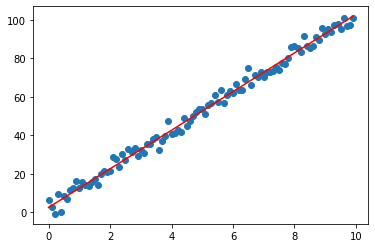

In [35]:
plt.plot(x_val, y_val, 'o')
plt.plot(x_val, pred_np, 'r');

We succeeded in finding an optimal model using a network instead of the standard linear regresssion!

## Mini-batches

In the above example, we use the whole dataset at each optimization step. We could do it because our training data is tiny. However, when working with larger datasets, this is usually not possible. One then splits the dataset into smaller groups, **mini-batches** and feeds those to the model at each iteration. In fact, it is know empirically that this approach is even **better** than to use the whole dataset in one go.

So we can rewrite our loop, and at each iteration take only e.g. 10 elements. As we have 100 data points, we need 10 iteration to go through the full dataset. Such a complete pass is an **epoch**. So when we do our training we now have two loops: one that does multiple epochs, and one which, within an epoch goes through the full dataset:

In [37]:
for j in range(10):
    for i in range(10):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs = x_val[i*10:(i+1)*10]
        inputs = inputs[:, np.newaxis]
        targets = y_val[i*10:(i+1)*10]
        targets = targets[:, np.newaxis]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [38]:
predicted_torch = model(x_val[:,np.newaxis])

In [39]:
pred = np.ravel(predicted_torch.detach().numpy())

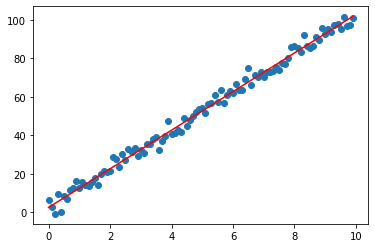

In [40]:
plt.plot(x_val, y_val, 'o')
plt.plot(x_val, pred, 'r')

## Adding layers

Instead of just considering a single layer, we can add multiple layers in our model. So now instead of having the output ```y``` directly after the first layer, we create an intermediate one. Of course now the first layer can output more than one value, but as many as we want. In the illustration below, the first layer has three inputs and generates two outputs. These two outputs are fed to a new layer that generates the final output ```y```:

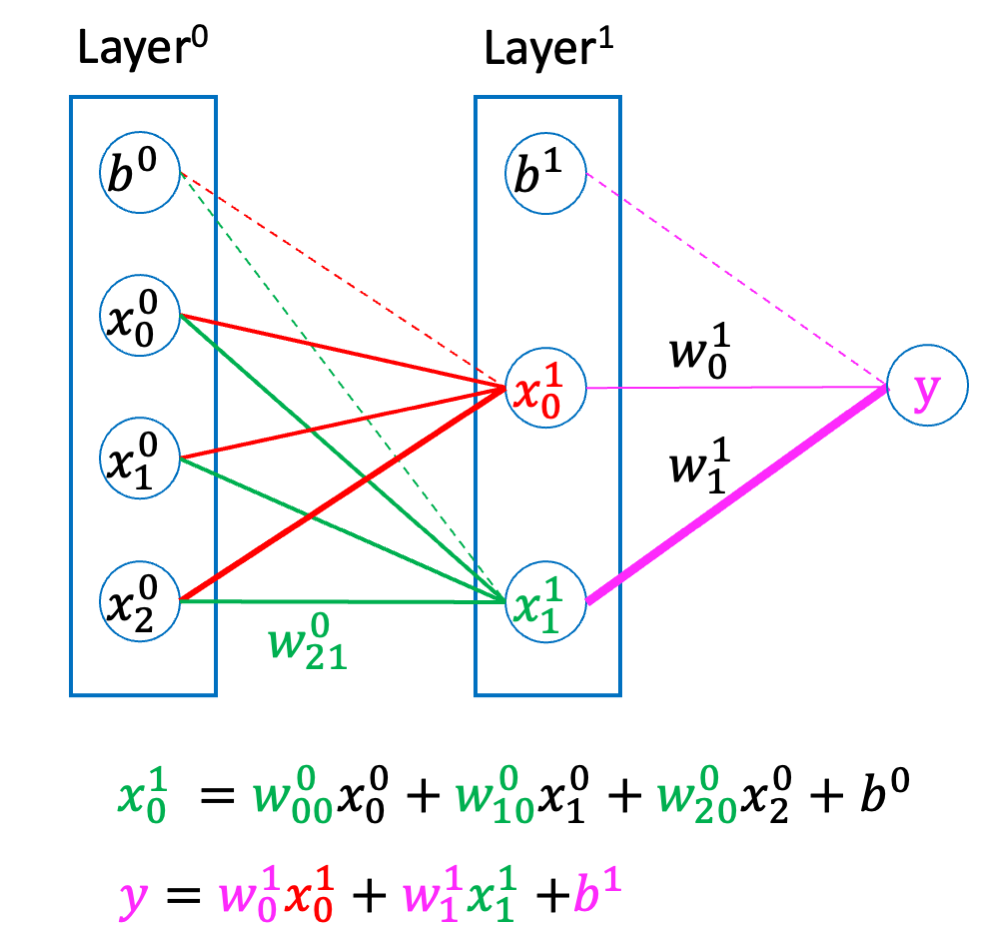

In [5]:
Image('images/networks/networks3.png', width=500)

When we work with multiple layers, we have to make sure that the outputs of a layer correspond to the inputs of the next one. For example we can take our input of 1 feature and have the first layer output 10 values. Those 10 values are then the input for the second layer which then gives the final output ```y```:

In [32]:
lin_layer1 = nn.Linear(in_features=1, out_features=10)
lin_layer2 = nn.Linear(in_features=10, out_features=1)

In [33]:
model_2 = nn.Sequential(lin_layer1, lin_layer2)

In [34]:
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

We can still use this model as before by just passing an input of the correct size, here just 1:

In [52]:
optimizer = optim.SGD(model_2.parameters(), lr=0.001)

for j in range(10):
    for i in range(10):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs = x_val[i*10:(i+1)*10]
        inputs = inputs[:, np.newaxis]
        targets = y_val[i*10:(i+1)*10]
        targets = targets[:, np.newaxis]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

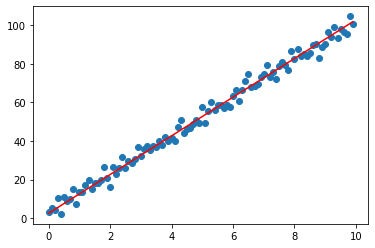

In [55]:
predicted_torch = model(x_val[:,np.newaxis])
pred = np.ravel(predicted_torch.detach().numpy())

plt.plot(x_val, y_val, 'o')
plt.plot(x_val, pred, 'r');

Now we can continue like this and add layer after layer. Such a model becomes seemingly increasingly complex, but in reality it can in the end be summarized as a linear model. Hence, such a model won't be able to fit anything more complex than lines! 

## Adding non linearities: activations

In previous chapters we have seen several times that linear relations are often not sufficient to model data. For example if when doing linear regression we added polynomial terms to describe complex dependencies between features, or in Support Vector Machines we could use higher degree kernels to classify points not separable by linear relations like lines and planes. Deep learning is used to model very complex data and thus absolutely *needs* the possibility to include non-linear effects. In the previous examples, even though we can had many layers, they were all linear, and therefore the complete network has to be linear.

The way to add non-linearity to the network is to use **activation functions**: instead of directly passing the output of a layer as input to the next one, we first pass it through a non-linear function as shown below:

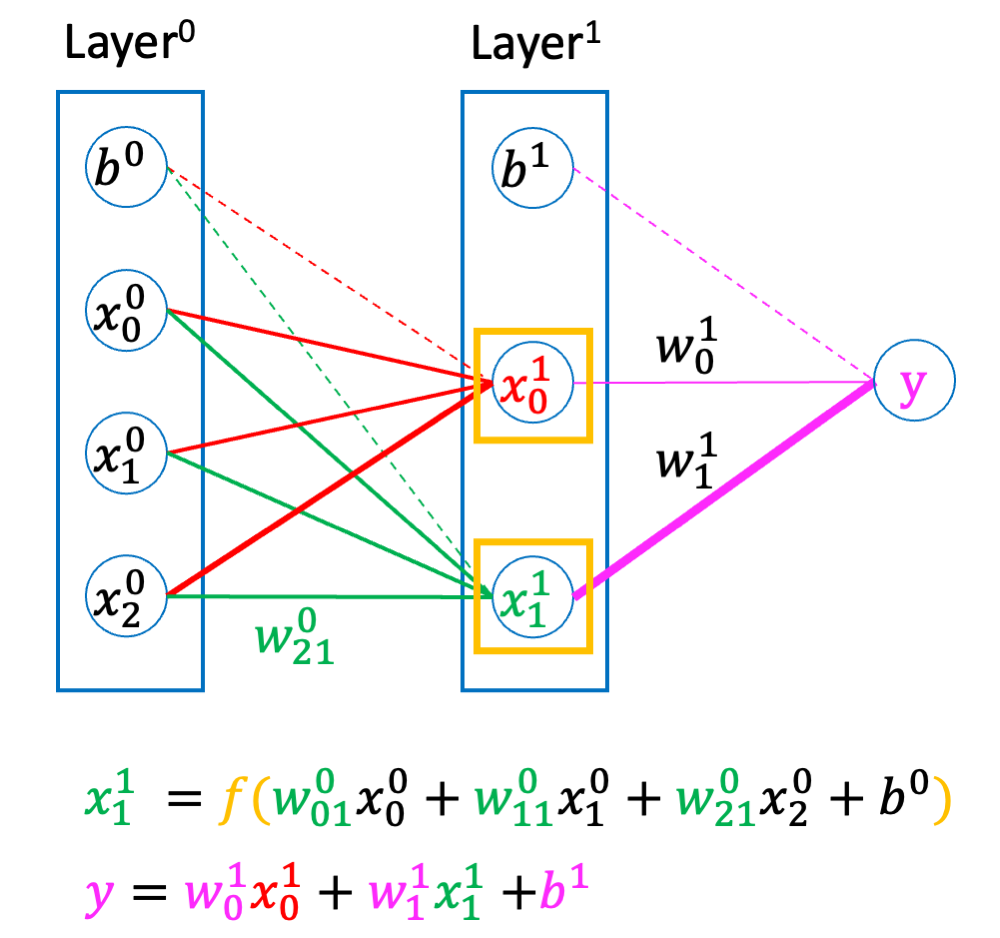

In [7]:
Image('images/networks/networks4.png', width=500)

The activation function $f$ can take many forms but *has to be non-linear*. Common examples are for example the sigmoid function (the same we saw in logistic regression), or the rectified linear unit or ReLU which looks like this:

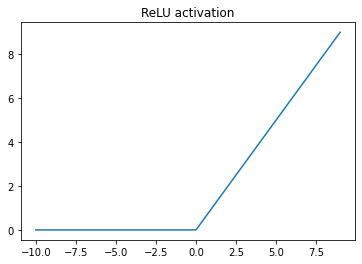

In [60]:
from torch.nn.functional import relu
fig, ax = plt.subplots()
ax.plot(torch.arange(-10,10), relu(torch.arange(-10,10)));
ax.set_title('ReLU activation');

The ReLU function takes an number $x$ in and gives 0 if $x<0$ and $x$ if $x>0$. It's a very simple non-linear function but sufficient to create complex models in a NN.

We try this out now on a non-linear signal generated by a cosine plus some noise:

In [84]:
x_val = torch.arange(0,10,0.1)
#y_val = 1 * x_val + 0.5*torch.tensor(np.random.randn(len(x_val)), dtype=torch.float32)
y_val = torch.cos(x_val) + 0.1*torch.tensor(np.random.randn(len(x_val)), dtype=torch.float32)

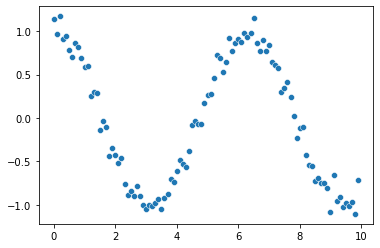

In [85]:
sns.scatterplot(x=x_val, y=y_val);

When we used linear regression, the solution to this was feature engineering: based on some knowledge we had (the curve oscillates) we could have added a features ```cos(x)``` in our linear model to introduce some non-linearity.

In a NN we only have to use a few layers and pass each of them through a non-linear function like a ReLU. With enough data and a large enough network, the weights will adjust to model these data without any "hand-made" feature engineering.

Here we use a simple network with 1 input, and two layers of 64 nodes:

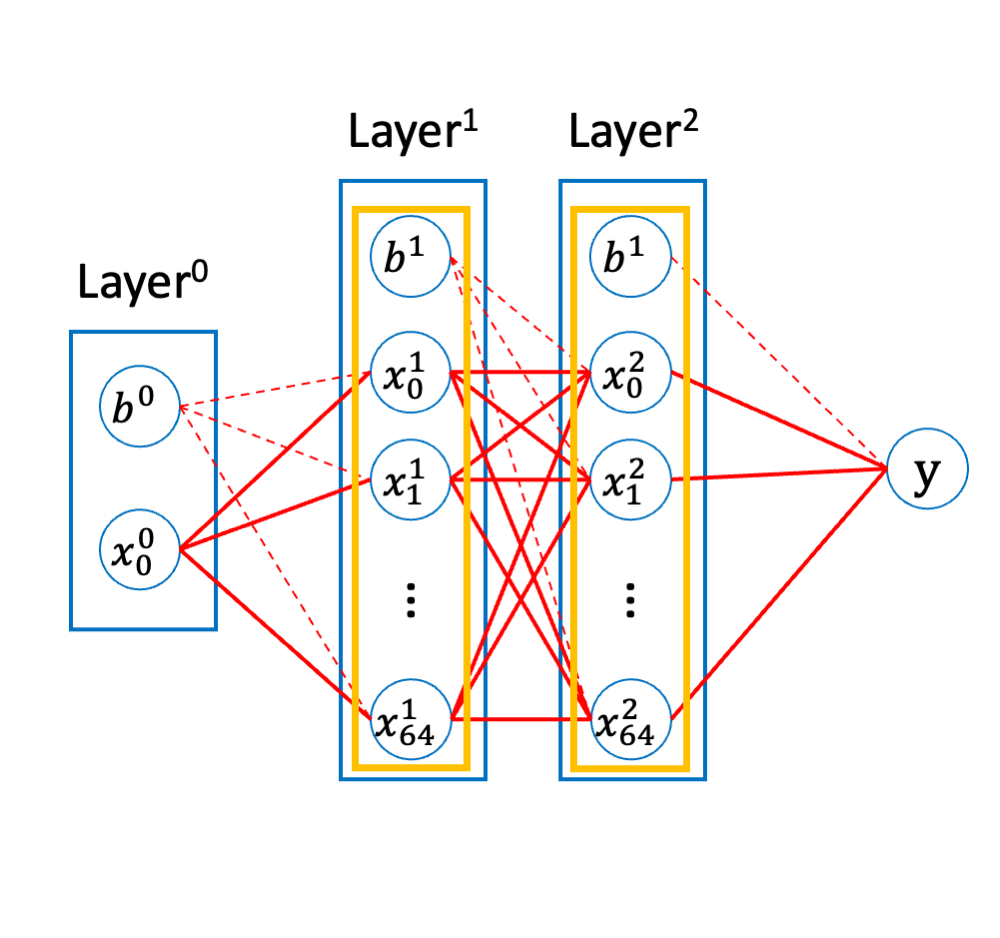

In [95]:
Image('images/networks/networks5.png', width=500)

In [96]:
lin_layer1 = nn.Linear(in_features=1, out_features=64)
lin_layer2 = nn.Linear(in_features=64, out_features=64)
lin_layer3 = nn.Linear(in_features=64, out_features=1)

model_2 = nn.Sequential(
    lin_layer1, nn.ReLU(), lin_layer2, nn.ReLU(), lin_layer3)

In [97]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001)

We train the model only on the first half of the datapoints in order to see the difference between points used for training and the others. We have a 100 points, so we use only the 50 first and train in batches of 10:

In [98]:
for j in range(10000):
    for i in range(5):
        
        inputs = x_val[i*10:(i+1)*10]
        inputs = inputs[:, np.newaxis]
        targets = y_val[i*10:(i+1)*10]
        targets = targets[:, np.newaxis]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [99]:
predicted_torch = model_2(x_val[:,np.newaxis])
pred = np.ravel(predicted_torch.detach().numpy())

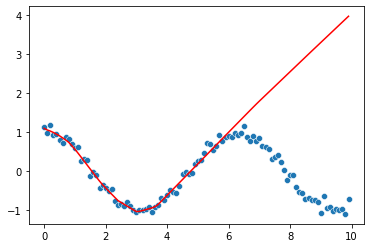

In [101]:
sns.scatterplot(x=x_val, y=y_val);
plt.plot(x_val, pred,'r-');

The model generated by the neural network is shown in red. We see that it matches exactly the data points up to the middle. As the model never saw the following points, the model then completely diverges.

## Neural networks vs. custom models

The above plot shows one of the main differences between Deep Learning based methods and classical methods. When using a classical method we have to come up at least partially with a model that could represent our data. By doing that the model becomes automatically more general. For example if we had defined an oscillatory model, even if we had used only the first half the data it could have described the second half as well, as the behavior is the same. In the case of the NN, the model is "dumber": it only manages to model data it has previously seen. Hence even though the second half of the data behaves identically to the first one, it is totally incapable of catching this general behavior.

## Overfitting

A common issue in Deep Learning is over- and under-fitting. We have see in previous chapters that we could use for example a very high degree polynomial regression on a part of our dataset, but that the model obtained was not general enough: when applied to another part of the data the fit would be very bad.

We encounter the same problem in deep learning as these models can have millions of parameters. For this reason, during the optimization loop, we need to constantly check the quality of our model. As done previously, we split our dataset into a training and testing set. Every time our model has been trained on the complete dataset (an epoch) we check its quality (e.g. with MSE for regression or accuracy for classification) on the test data. If a model trains correctly, initially the model quality improves both for training and testing dataset. After a number of iterations, the model is trained optimally, but if we continue training, it will start to "mimic the training data" and loose its generality. By loosing this generality, its efficiency on the testing set (which it never sees during training) will decrease, i.e. the error on the testing set will increase. 

In order to demonstrate this, we try to fit a simple line to some noise data. Note that we have very little data (30 points) and keep 20 for training:

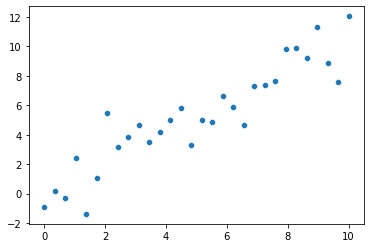

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

np.random.seed(40)
x_val = torch.linspace(0,10,30)
y_val = 1 * x_val + 1.5*torch.tensor(np.random.randn(len(x_val) ), dtype=torch.float32)

dataset = pd.DataFrame({'x_val': x_val, 'y_val': y_val})

dataset_train, dataset_test = train_test_split(dataset, test_size=0.32, random_state=42)

sns.scatterplot(x=x_val, y=y_val);

In [456]:
dataset_train.shape

(20, 2)

Now we defined the same type of model as above, and train it for 1000 epochs. At each epoch, we keep track of the MSE of the test dataset in the ```errors_test``` list:

In [457]:
lin_layer1 = nn.Linear(in_features=1, out_features=64)
lin_layer2 = nn.Linear(in_features=64, out_features=64)
lin_layer3 = nn.Linear(in_features=64, out_features=64)
lin_layer4 = nn.Linear(in_features=64, out_features=1)

model_2 = nn.Sequential(
    lin_layer1, nn.ReLU(), lin_layer2, nn.ReLU(), lin_layer3, nn.ReLU(), lin_layer4)

criterion = nn.MSELoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001)

errors_test = []
errors_train = []
for j in range(20000):
    for i in range(2):
        
        inputs = torch.tensor(dataset_train.iloc[i*10:(i+1)*10][['x_val']].values)
        targets = torch.tensor(dataset_train.iloc[i*10:(i+1)*10][['y_val']].values)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    inputs_test = torch.tensor(dataset_test[['x_val']].values)
    predicted_test = model_2(inputs_test)
    
    inputs_train = torch.tensor(dataset_train[['x_val']].values)
    predicted_train = model_2(inputs_train)
    
    errors_test.append(mean_squared_error(predicted_test.detach().numpy(), dataset_test[['y_val']].values))
    errors_train.append(mean_squared_error(predicted_train.detach().numpy(), dataset_train[['y_val']].values))


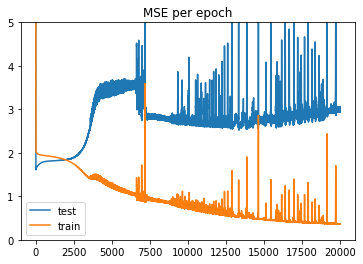

In [460]:
fig, ax = plt.subplots()
ax.plot(errors_test, label='test')
ax.plot(errors_train, label='train')
#ax.set_ylim(1.5,2.5);
ax.set_ylim(0.,5);
ax.legend()
ax.set_title('MSE per epoch');

We see on the plot above for the test curve that the the model quickly finds an optimum (as we have very little data) and that then the MSE increases again. In contrast, for the training set the error steadily decreases (except for a few outliers. This is a typical example of over-fitting. We can check what happens at the single point level: in the training data, the model almost perfectly matches some of the points. Naturally, when it tries to predict the points of the test set, it fails. The perfect matching of the points in the training dataset exactly shows over-fitting: instead of creating a general model, we created one that can only reproduce a very specific set of points!

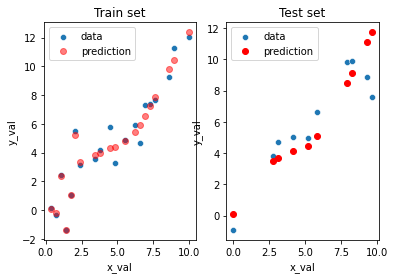

In [469]:
fig, ax = plt.subplots(1,2)

pred_train = model_2(torch.tensor(dataset_train[['x_val']].values))
pred_train = np.ravel(pred_train.detach().numpy())

pred_test = model_2(torch.tensor(dataset_test[['x_val']].values))
pred_test = np.ravel(pred_test.detach().numpy())

sns.scatterplot(x=dataset_test['x_val'], y=dataset_test['y_val'], ax=ax[1], label='data');
ax[1].plot(dataset_test['x_val'], pred_test,'ro', label='prediction');
ax[1].legend()
ax[1].set_title('Test set')
sns.scatterplot(x=dataset_train['x_val'], y=dataset_train['y_val'], ax=ax[0], label='data');
ax[0].plot(dataset_train['x_val'], pred_train,'ro', alpha=0.5, label='prediction');
ax[0].legend();
ax[0].set_title('Train set');

## On real data

To finish, we use the type of network described above to model the same data we modeled previously using linear regression. In the wine dataset, we want to describe the relation between ```density``` and ```fixed acidity```.

In [492]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')


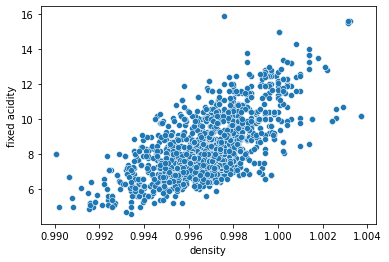

In [493]:
fig, ax = plt.subplots()
sns.scatterplot(data=wine, x='density', y='fixed acidity');

First we extract the relevant data from the dataframe and scale the data using the standard scaler. Neural networks are very sensitive to the scale of data and very often it helps to normalize them:

In [494]:
dataset = wine[['density', 'fixed acidity']]
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
dataset = std_scaler.fit_transform(dataset)

dataset = pd.DataFrame({'density': dataset[:,0],'fixed acidity': dataset[:,1]})

Then we treat the data as we did for the simple synthetic example from above: we create a train and test set and train our model:

In [495]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.3, random_state=42)

In [496]:
lin_layer1 = nn.Linear(in_features=1, out_features=64)
lin_layer2 = nn.Linear(in_features=64, out_features=64)
lin_layer3 = nn.Linear(in_features=64, out_features=64)
lin_layer4 = nn.Linear(in_features=64, out_features=1)

model_2 = nn.Sequential(
    lin_layer1, nn.ReLU(), lin_layer2, nn.ReLU(), lin_layer3, nn.ReLU(), lin_layer4)

criterion = nn.MSELoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001)

errors_test = []
errors_train = []
for j in range(200):
    for i in range(10):
        
        inputs = torch.tensor(dataset_train.iloc[i*100:(i+1)*100][['density']].values.astype(np.float32))
        targets = torch.tensor(dataset_train.iloc[i*100:(i+1)*100][['fixed acidity']].values.astype(np.float32))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    inputs_test = torch.tensor(dataset_test[['density']].values.astype(np.float32))
    predicted_test = model_2(inputs_test)
    
    inputs_train = torch.tensor(dataset_train[['density']].values.astype(np.float32))
    predicted_train = model_2(inputs_train)
    
    errors_test.append(mean_squared_error(predicted_test.detach().numpy(), dataset_test[['fixed acidity']].values.astype(np.float32)))
    errors_train.append(mean_squared_error(predicted_train.detach().numpy(), dataset_train[['fixed acidity']].values.astype(np.float32)))


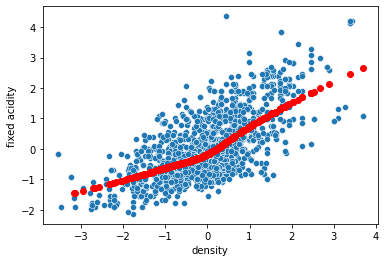

In [497]:
fig, ax = plt.subplots()
sns.scatterplot(data=dataset, x='density', y='fixed acidity', ax=ax);

pred_test = model_2(torch.tensor(dataset_test[['density']].values.astype(np.float32)))
pred_test = np.ravel(pred_test.detach().numpy())

ax.plot(dataset_test['density'], pred_test,'ro', label='prediction');


## Exercise

Try to replicate the modeling of the exercise in Chapter 7 by training a neural network predicting the ```price``` vs ```sqft_living``` relation in the housing dataset. You can re-use the neural network and the training loop define above and replace the variables with the appropriate names. Be also careful to loop over all batches of the data.
